# Gestion des données et des fonctionnalités

Dans ce chapitre, nous allons ajouter une couche de données de gestion des fonctionnalités à la plate-forme d'apprentissage automatique en cours de construction. Nous tirerons parti des fonctionnalités du module MLflow Projects pour structurer notre pipeline de données. En particulier, nous examinerons les sections suivantes de ce chapitre : 

* Structurer votre projet de pipeline de données
* Acquérir des données de stock 
* Vérifier la qualité des données 
* Gestion des fonctionnalités

Dans ce chapitre, nous allons acquérir des données pertinentes pour fournir des ensembles de données pour la formation. Notre principale ressource sera l'ensemble de données Yahoo Finance Data pour BTC. Parallèlement à ces données, nous acquerrons les ensembles de données supplémentaires suivants

Tirant parti de notre architecture de production introduite au chapitre 6, Présentation de l'architecture des systèmes de ML, représentée à la figure 7.1, le composant fonctionnalité et données est responsable de l'acquisition des données à partir des sources et de la mise à disposition des données dans un format utilisable par les diérents composants de la plate-forme.

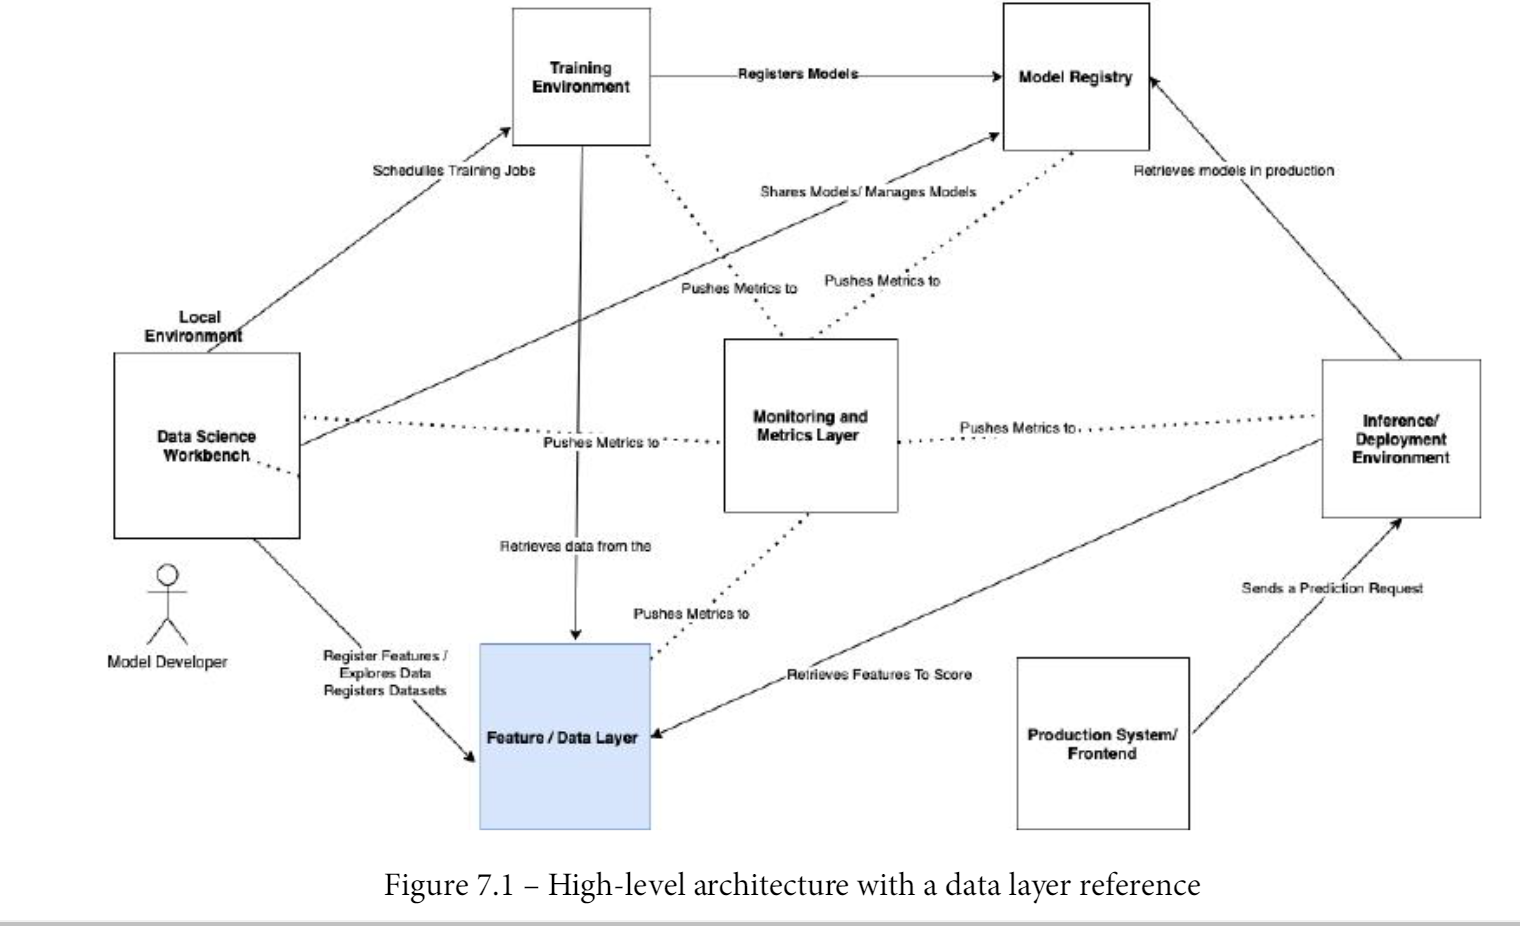

Examinons ce chapitre et voyons comment nous allons structurer et remplir la couche de données avec les données pertinentes à utiliser pour l'entraînement des modèles et la génération de fonctionnalités

## Structurer votre projet de pipeline de données

À un niveau élevé, notre pipeline de données s'exécutera chaque semaine, collectant les données des 7 jours précédents et les stockant d'une manière qui peut être exécutée par des tâches d'apprentissage automatique pour générer des modèles en amont. Nous allons structurer nos dossiers de données en trois types de données :

* Données brutes : un ensemble de données généré en récupérant les données de l'API Yahoo Finance pour les 90 derniers jours. Nous stockerons les données au format CSV - le même format que celui dans lequel elles ont été reçues de l'API. Nous enregistrerons l'exécution dans MLflow et extrairons le nombre de lignes collectées. 

* Données échelonnées : sur les données brutes, nous effectuerons des contrôles de qualité, une vérication du schéma et conrmerons que les données peuvent être utilisées en production. Ces informations sur la qualité des données seront enregistrées dans MLflow Tracking
* Données d'entraînement : les données d'entraînement sont le produit final du pipeline de données. Il doit être exécuté sur des données jugées propres et adaptées à l'exécution de modèles. Les données contiennent les données transformées en fonctionnalités qui peuvent être utilisées directement pour le processus de formation.

Cette structure de dossiers sera initialement implémentée sur le système de fichiers et sera transposée dans l'environnement pertinent (exemples : AWS S3, Kubernetes PersistentVolume, etc.) lors du déploiement

Afin d'exécuter notre projet de pipeline de données, nous utiliserons le module MLflow Project pour conditionner le pipeline de données dans un format indépendant de l'environnement d'exécution. Nous utiliserons le format Docker pour packager le projet MLflow. Le format Docker nous offre différentes options pour déployer notre projet dans le cloud ou sur site en fonction de l'infrastructure disponible pour déployer notre projet :

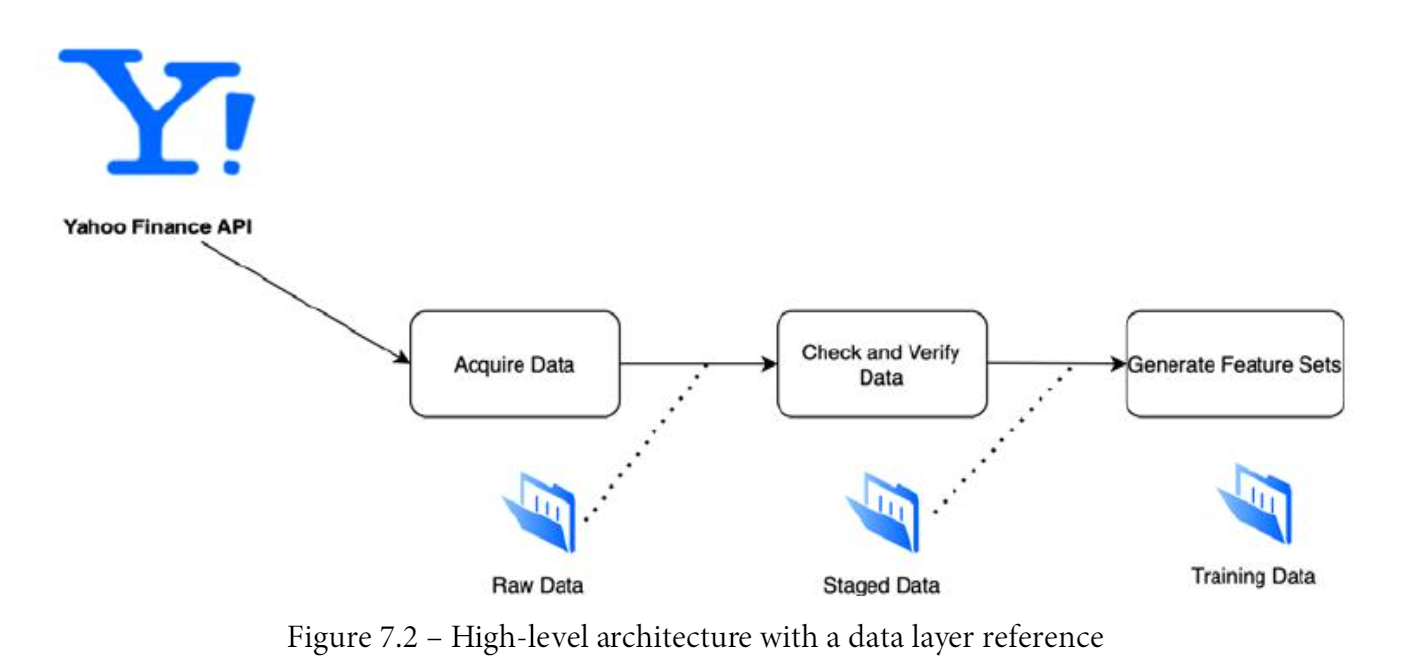

## Notre flux de travail exécutera les étapes suivantes, comme illustré à la figure 7.2:1. 

* 1. Acquérir des données : il est chargé de récupérer les données de l'API et de les enregistrer en tant que fichier CSV dans le dossier data/raw/data.csv.2. 

* 2. Check and Verify Data : il est chargé de vérifier si les données fournies répondent aux exigences de qualité du pipeline de données, et si c'est le cas, il rapportera différentes métriques et écrira les données dans le fichier data/staged/data.csv. 

* 3. Générer des ensembles de fonctionnalités : sur la base des données mises en scène, cela transformera les données dans un format consommable par le code d'apprentissage automatique et produira un nouvel ensemble de données d'entraînement à l'emplacement data/training/data.csv


Avec ces trois phases distinctes, nous assurons la reproductibilité du processus de génération de données de formation, la visibilité et une séparation claire des différentes étapes du processus. Nous commencerons par organiser notre projet MLflow en étapes et créer des espaces réservés pour chaque des composants du pipeline:

1. Créez un nouveau dossier sur votre machine locale avec le nom psytock-data-features

2. Ajoutez le fichier MLProject :


    name: pystock_data_features

    conda_env: conda.yaml

    entry_points:

      load_raw_data:
        command: "python load_raw_data.py"

      clean_validate_data:
        command: "python check_verify_data.py "

      feature_set_generation:
        command: "python feature_set_generation.py"

      main:
        command: "python main.py"

3. Ajoutez le fichier conda.yaml suivant :


    name: pystock-data-features
    channels:
      - defaults
    dependencies:
      - python=3.8
      - numpy
      - scipy
      - pandas
      - cloudpickle
      - pip:
        - git+git://github.com/mlflow/mlflow
        - pandas_datareader
        - great-expectations==0.13.15
        - pandas-profiling


4. Vous pouvez maintenant ajouter un exemple de fichier main.py au dossier pour vous assurer que la structure de base du projet fonctionne :

In [ ]:
import mlflow
import click

def _run(entrypoint, parameters={}, source_version=None, use_cache=True):
    #existing_run = _already_ran(entrypoint, parameters, source_version)
    #if use_cache and existing_run:
    #    print("Found existing run for entrypoint=%s and parameters=%s" % (entrypoint, parameters))
     #   return existing_run
    print("Launching new run for entrypoint=%s and parameters=%s" % (entrypoint, parameters))
    submitted_run = mlflow.run(".", entrypoint, parameters=parameters)
    return submitted_run


@click.command()
def workflow():
    with mlflow.start_run(run_name ="pystock-data-pipeline") as active_run:
        mlflow.set_tag("mlflow.runName", "pystock-data-pipeline")
        _run("load_raw_data")
        _run("clean_validate_data")
        _run("feature_set_generation")
        
        
if __name__=="__main__":
    workflow()

5. Testez la structure de base en exécutant la commande suivante :

Cette commande va construire votre projet en fonction de l'environnement créé par votre fichier conda.yaml et exécuter le projet de base que vous venez de créer. Il devrait y avoir une erreur car nous devons ajouter les fichiers manquants. L'erreur le not found ressemblera à ceci :


    python: can't open file 'check_verify_data.py': [Errno 2] No such file or directory



À ce stade, nous avons les blocs de base du projet MLflow du pipeline de données que nous allons construire dans ce chapitre. Nous allons ensuite remplir le script Python pour acquérir les données dans la section suivante

## Acquisition de données de stock

Notre script pour acquérir les données sera basé sur le package Python pandas-datareader. Il fournit une abstraction simple aux API financières distantes que nous pouvons exploiter à l'avenir dans le pipeline. L'abstraction est très simple. Étant donné une source de données telle que Yahoo Finance, vous fournissez le ticker/paire d'actions et la plage de dates, et les données sont fournies dans un DataFrame. Nous allons maintenant créer le fichier load_raw_data.py, qui sera chargé de charger les données et de les enregistrer. dans le dossier brut. Vous pouvez consulter le contenu du fichier dans le référentiel à l'adresse https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/blob/master/Chapter07/psystock-data-features-main/load_raw_data.py. Exécutez les étapes suivantes pour implémenter le fichier :


1. Nous commencerons par importer les packages concernés :

In [ ]:
import mlflow
from datetime import date
from dateutil.relativedelta import relativedelta
import pprint
import pandas_datareader
import pandas
import requests

import pandas_datareader.data as web

2. Ensuite, vous devez ajouter une fonction pour récupérer les données :

In [ ]:
if __name__ == "__main__":

    #Workaround to handle issue https://github.com/pydata/pandas-datareader/issues/868
    USER_AGENT = {
        'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'
                    ' Chrome/91.0.4472.124 Safari/537.36')
        }
    sesh = requests.Session()
    sesh.headers.update(USER_AGENT)

    
    with mlflow.start_run(run_name="load_raw_data") as run:

        mlflow.set_tag("mlflow.runName", "load_raw_data")
        end = date.today()
        start = end + relativedelta(months=-3)
	
        
        df = web.DataReader("BTC-USD", 'yahoo', start, end, session=sesh)

        df.to_csv("./data/raw/data.csv")

Maintenant que nous avons acquis les données, nous devons appliquer les meilleures pratiques que nous aborderons dans la section suivante - une approche pour vérifier la qualité des données acquises.

## Checking data quality

La vérification de la qualité des données dans le cadre de votre système d'apprentissage automatique est extrêmement critique pour garantir l'intégrité et l'exactitude de la formation et de l'inférence de votre modèle. Les principes de test et de qualité des logiciels doivent être empruntés et utilisés sur la couche de données des plates-formes d'apprentissage automatique. Du point de vue de la qualité des données, dans un ensemble de données, il existe quelques dimensions critiques avec lesquelles évaluer et profiler nos données, à savoir :

* Conformité du schéma : s'assurer que les données sont des types attendus ; s'assurer que les valeurs numériques ne contiennent aucun autre type de données * ,Données valides : évaluer du point de vue des données si les données sont valides d'un point de vue commercial

* Données manquantes : évaluer si toutes les données nécessaires pour exécuter des analyses et des algorithmes sont disponibles


Pour la validation des données, nous utiliserons le package Python Great Expectations (disponible sur https://github.com/great-expectations/great_expectations). Il permet de faire des assertions sur les données avec de nombreux packages compatibles avec les données, tels que les environnements pandas, Spark et cloud. Il fournit un DSL en JSON avec lequel déclarer les règles avec lesquelles nous voulons que nos données soient conformes. Pour notre projet actuel, nous voulons que les règles/contraintes suivantes soient vérifiables : 

* Les valeurs de date doivent être des dates valides et ne peuvent pas être manquant.
* Vérifiez que les valeurs numériques et longues sont correctement saisies.

* Toutes les colonnes sont présentes dans l'ensemble de données


Nous allons maintenant créer le fichier check_verify_data.py, qui sera chargé de charger les données et de les enregistrer dans le dossier intermédiaire où toutes les données sont valides et prêtes à être utilisées pour la formation ML. Vous pouvez consulter le contenu du fichier dans le référentiel à l'adresse https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/blob/master/Chapter07/psystock-data-features-main/check_verify_data. py.

1. Afin de convertir les règles précédentes afin qu'elles puissent être utilisées par notre système, nous devrons importer les dépendances suivantes :

In [ ]:
import mlflow
from datetime import date
from dateutil.relativedelta import relativedelta
import pprint
import pandas_datareader
import pandas
from pandas_profiling import ProfileReport
import great_expectations as ge
from great_expectations.profile.basic_dataset_profiler import BasicDatasetProfiler

2. Ensuite, nous allons implémenter le script :

In [ ]:
if __name__ == "__main__":
    with mlflow.start_run(run_name="check_verify_data") as run:

        mlflow.set_tag("mlflow.runName", "check_verify_data")

        df = pandas.read_csv("./data/raw/data.csv")

        describe_to_dict=df.describe().to_dict()
        mlflow.log_dict(describe_to_dict,"describe_data.json")

        pd_df_ge = ge.from_pandas(df)

        assert pd_df_ge.expect_column_values_to_match_strftime_format("Date", "%Y-%m-%d").success == True
        assert pd_df_ge.expect_column_values_to_be_of_type("High", "float").success == True
        assert pd_df_ge.expect_column_values_to_be_of_type("Low", "float").success == True
        assert pd_df_ge.expect_column_values_to_be_of_type("Open", "float").success == True
        assert pd_df_ge.expect_column_values_to_be_of_type("Close", "float").success == True
        assert pd_df_ge.expect_column_values_to_be_of_type("Volume", "long").success == True
        assert pd_df_ge.expect_column_values_to_be_of_type("Adj Close", "float").success == True

        #we can do some basic cleaning by dropping the null values
        df.dropna(inplace=True)

        #if data_passes_quality_can_go_to_features:
        df.to_csv("data/staging/data.csv")

Après avoir vérifié la qualité des données et la mise en scène à utiliser, il peut maintenant être utilisé pour la génération de fonctionnalités avec un degré élevé de confiance.

## Générer un ensemble de fonctionnalités et des données d'entraînement

Nous allons refactoriser un peu du code précédemment développé dans notre environnement local pour générer des fonctionnalités d'entraînement afin d'ajouter à notre projet MLflow le pipeline de données de notre projet MLflow. Nous allons maintenant créer le feature_set_generation.py fichier, qui sera chargé de générer nos fonctionnalités et de les enregistrer dans le dossier de formation où toutes les données sont valides et prêtes à être utilisées pour la formation ML. Vous pouvez consulter le contenu du fichier dans le référentiel https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/blob/master/Chapter07/psystock-data-features-main/feature_set_generation.py :

1. Nous devons importer les dépendances suivantes :

In [ ]:
import mlflow
from datetime import date
from dateutil.relativedelta import relativedelta
import pprint
import pandas as pd
import pandas_datareader
import pandas_datareader.data as web
import numpy as np

2. Avant d'approfondir le composant principal du code, nous allons maintenant procéder à la mise en œuvre d'une fonction critique pour générer les fonctionnalités en transformant essentiellement la différence avec chaque n jour précédent en une fonctionnalité que nous utiliserons pour prédire le jour suivant. , très similaire à l'approche que nous avons utilisée dans les chapitres précédents du guide pour notre cas d'utilisation en cours d'exécution

In [ ]:
def rolling_window(a, window):
    """
        Takes np.array 'a' and size 'window' as parameters
        Outputs an np.array with all the ordered sequences of values of 'a' of size 'window'
        e.g. Input: ( np.array([1, 2, 3, 4, 5, 6]), 4 )
             Output: 
                     array([[1, 2, 3, 4],
                           [2, 3, 4, 5],
                           [3, 4, 5, 6]])
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

3. Ensuite, nous allons procéder à la lecture du fichier intermédiaire qui est considéré comme propre et prêt à être utilisé par les processus en amont :

In [ ]:
if __name__ == "__main__":
    with mlflow.start_run() as run:

        mlflow.set_tag("mlflow.runName", "feature_set_generation")

        raise Exception('x should not exceed 5. The value of x was: {}'.format(x))

        btc_df = pd.read_csv("data/staging/data.csv")

        btc_df['delta_pct'] = (btc_df['Close'] - btc_df['Open'])/btc_df['Open']

        btc_df['going_up'] = btc_df['delta_pct'].apply(lambda d: 1 if d>0.00001 else 0).to_numpy()

        element=btc_df['going_up'].to_numpy()

        WINDOW_SIZE=15

        training_data = rolling_window(element, WINDOW_SIZE)

        pd.DataFrame(training_data).to_csv("data/training/data.csv")

Nous générons l'ensemble de fonctionnalités et les fonctionnalités. Nous sommes désormais en mesure d'exécuter tout le pipeline de bout en bout, de l'acquisition de données à la génération de fonctionnalités.

## Exécution de votre pipeline de bout en bout

Dans cette section, nous allons exécuter l'exemple complet, que vous pouvez récupérer à partir de l'adresse suivante pour le référentiel GitHub du livre dans le dossier /Chapter07/psytock-data-features-main. La figure 7.3 illustre la structure complète des dossiers du projet que vous pouvez inspecter dans GitHub et comparer avec votre version locale :

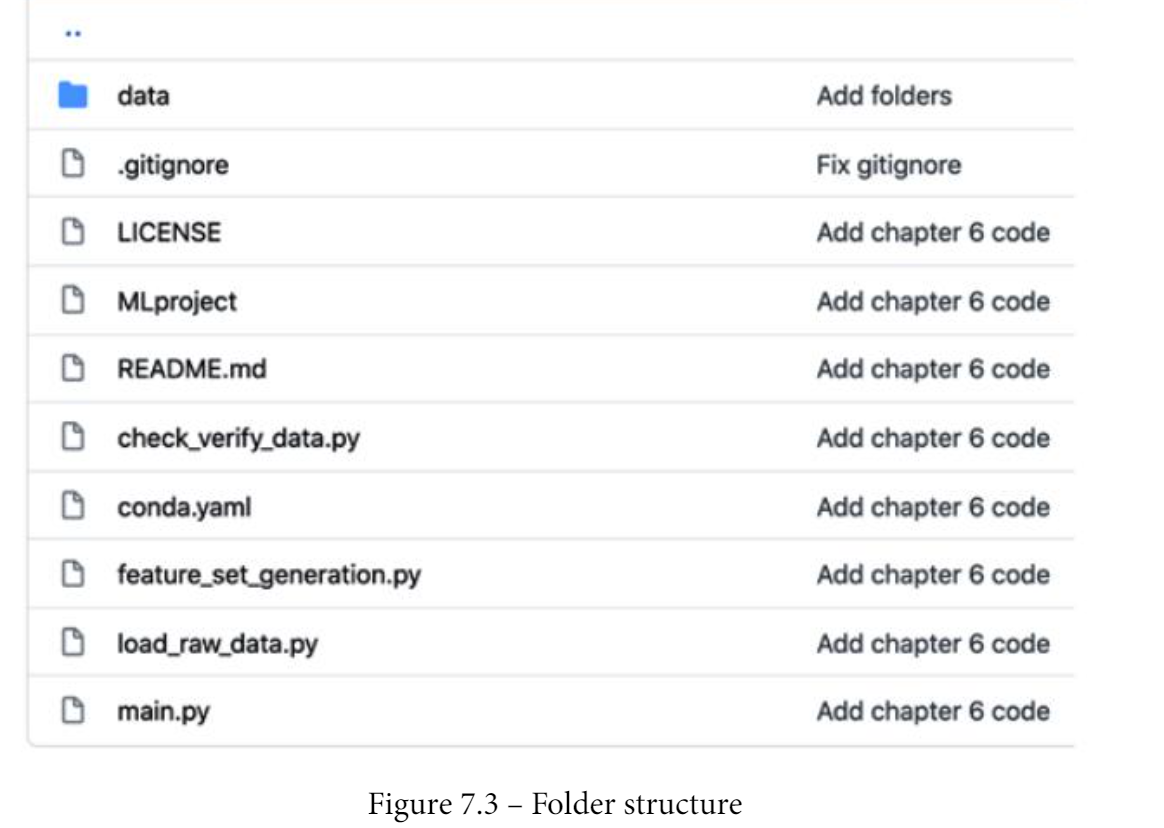

Pour exécuter le pipeline de bout en bout, vous devez exécuter la commande suivante dans le répertoire avec le code :


    mlflow run . --experiment-name=psystock_data_pipelines


Il exécutera essentiellement le pipeline de bout en bout et vous pourrez l'inspecter directement dans l'interface utilisateur MLflow, en exécutant chacune des étapes du pipeline dans l'ordre :


    mlflow ui


Dans la Figure 7.4, vous pouvez voir les différentes exécutions du projet principal et des sous-projets des étapes du pipeline dans un format de flux de travail imbriqué que vous pouvez parcourir pour inspecter les détails :


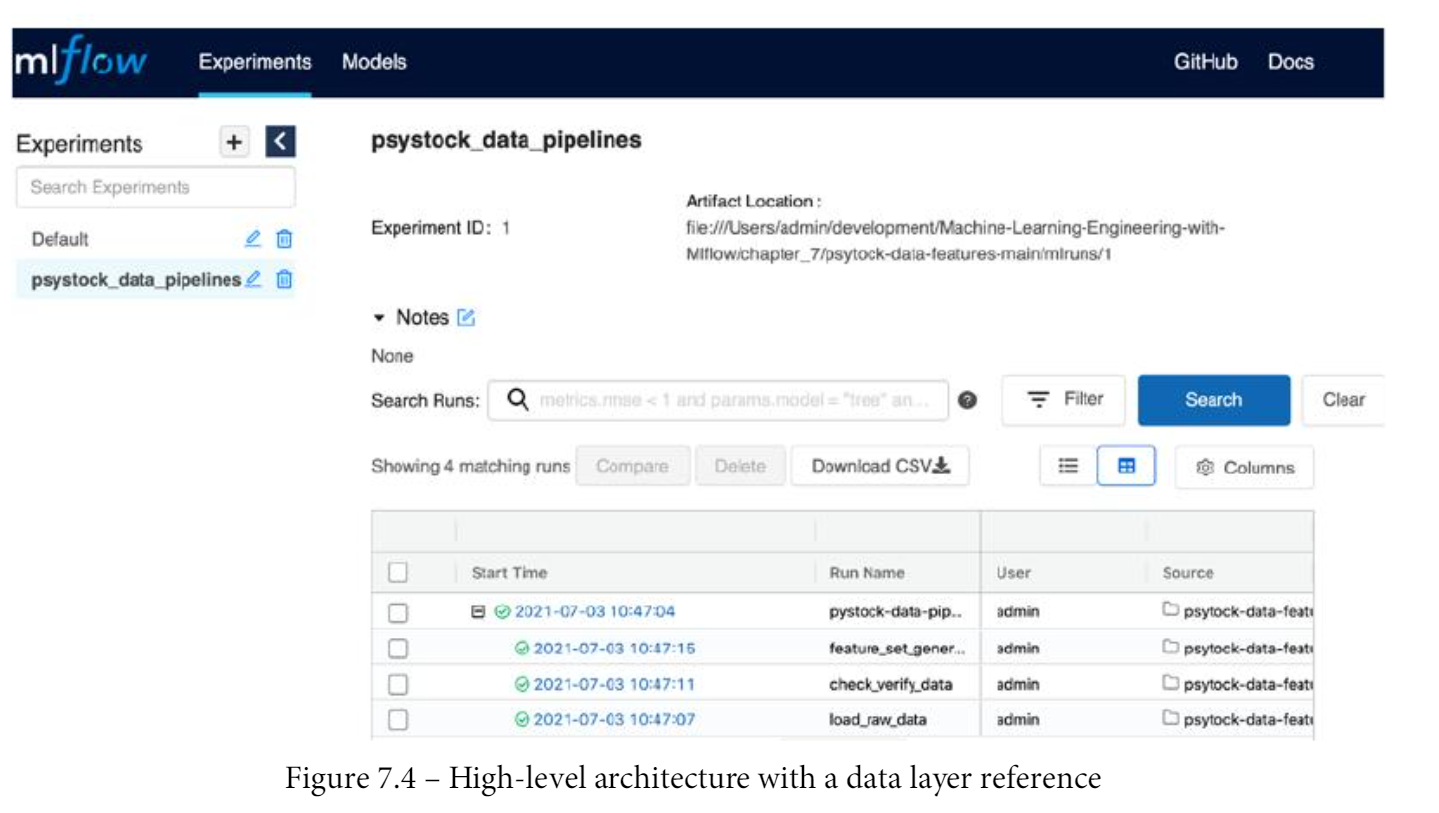

Dans la figure 7.5, vous pouvez voir la référence à la phase load_raw_data du pipeline de données et vérifier quand il a été démarré et arrêté et les paramètres utilisés :

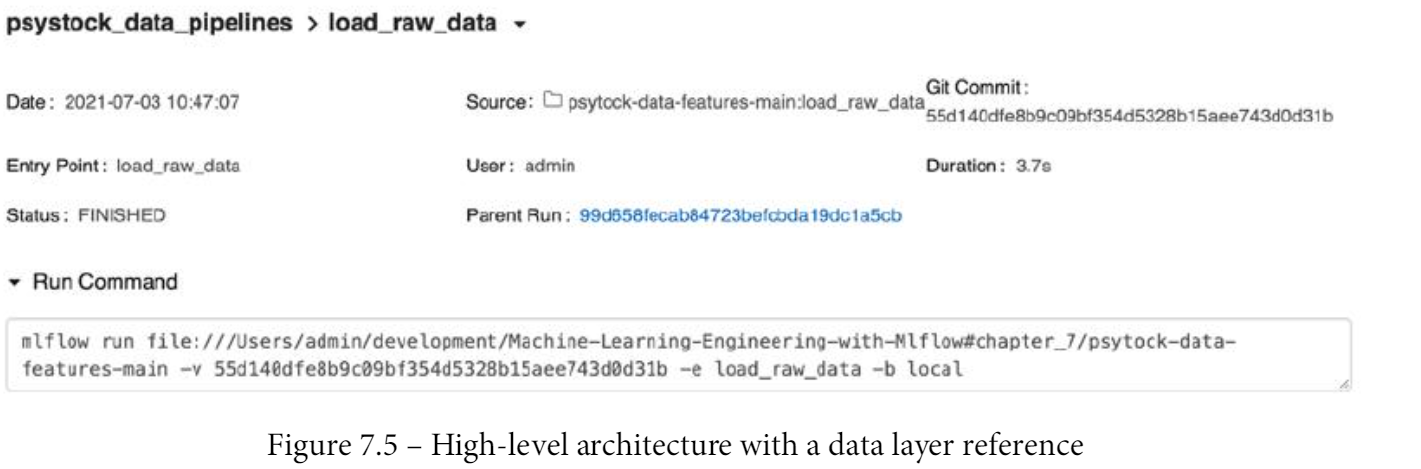

Dans la Figure.7.6, vous pouvez voir la référence à la phase check_verify_data du pipeline de données où nous avons enregistré des informations statistiques de base sur l'ensemble de données obtenu :

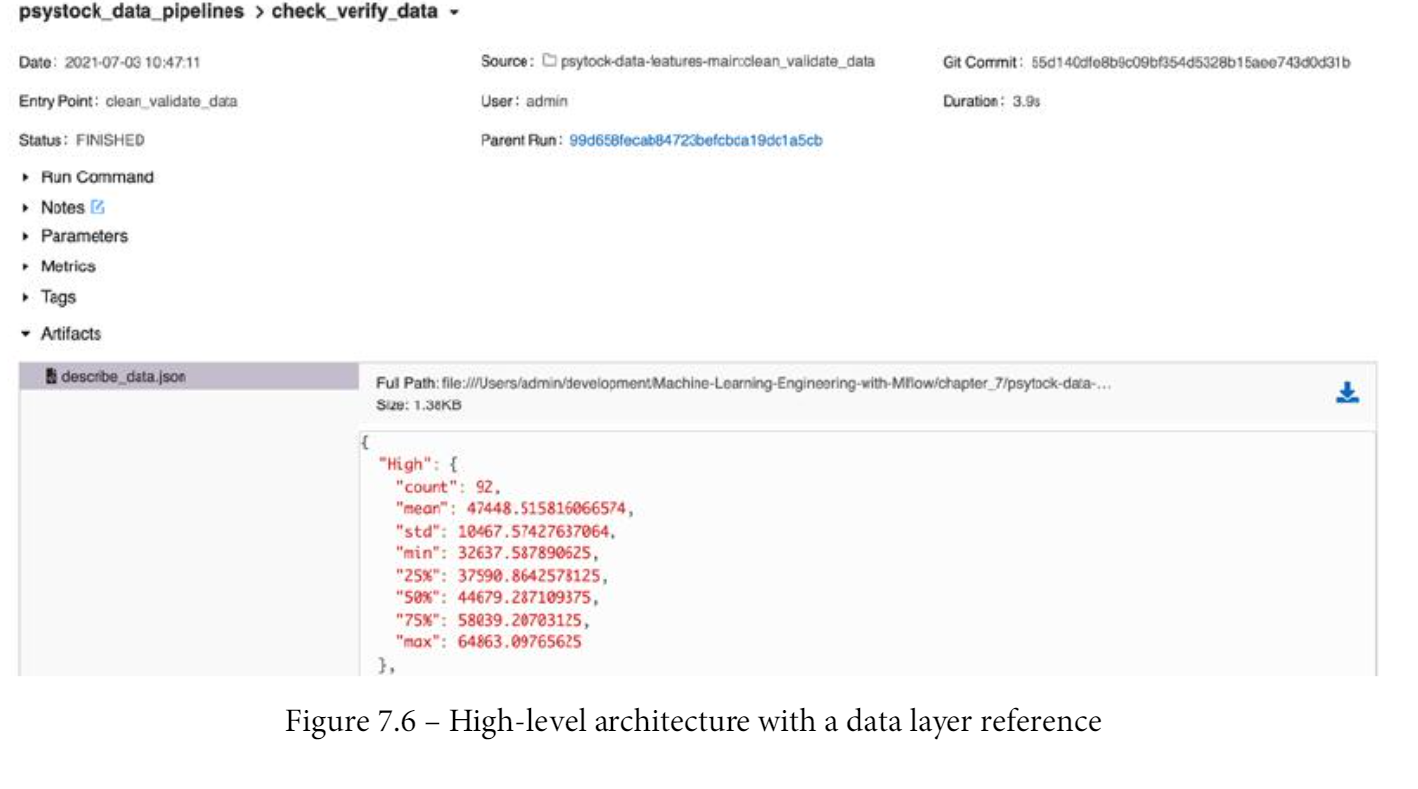


Si des problèmes de qualité des données sont détectés, le flux de travail échouera avec une indication claire de la section qui a échoué, comme représenté sur la Figure 7.7 :


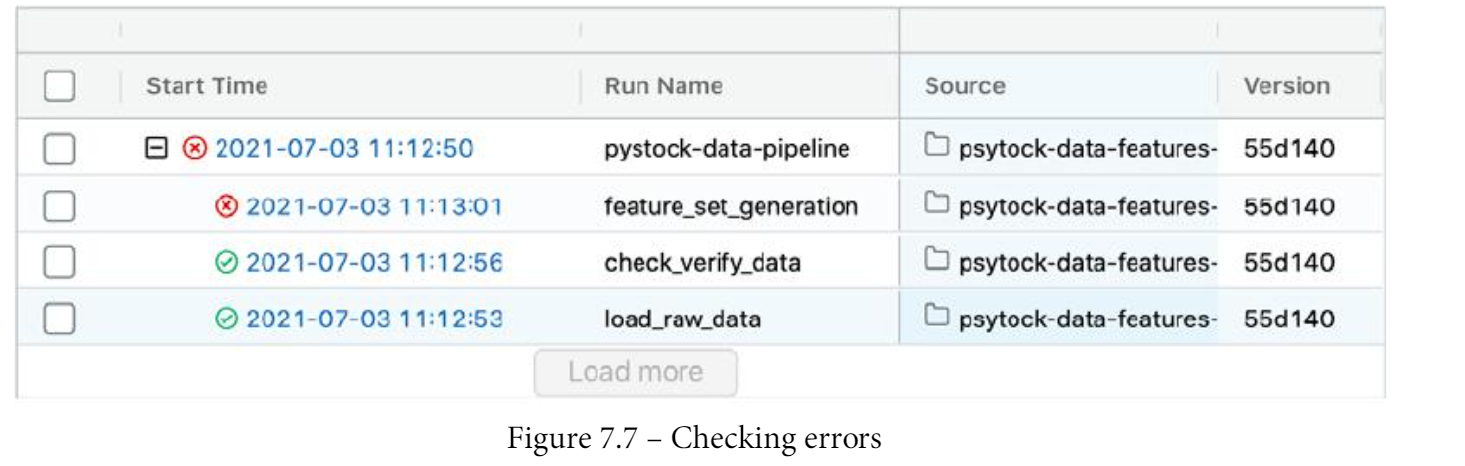

Avec cette section, nous avons conclu la description du processus de gestion des données et de génération de fonctionnalités dans un pipeline de données implémenté avec le module MLProjects dans MLflow. Nous allons maintenant voir comment gérer les données dans un magasin de fonctionnalités.

## Utilisation d'un magasin de fonctionnalités 


Un magasin de fonctionnalités est une couche logicielle au-dessus de vos données pour faire abstraction de tous les processus de production et de gestion des données en fournissant aux systèmes d'inférence une interface pour récupérer un ensemble de fonctionnalités pouvant être utilisé pour l'inférence ou la formation. Dans cette section, nous allons illustrer le concept d'un magasin de fonctionnalités à l'aide de Feast (un magasin de fonctionnalités), un système de données opérationnel pour gérer et proposer des fonctionnalités d'apprentissage automatique aux modèles en production :

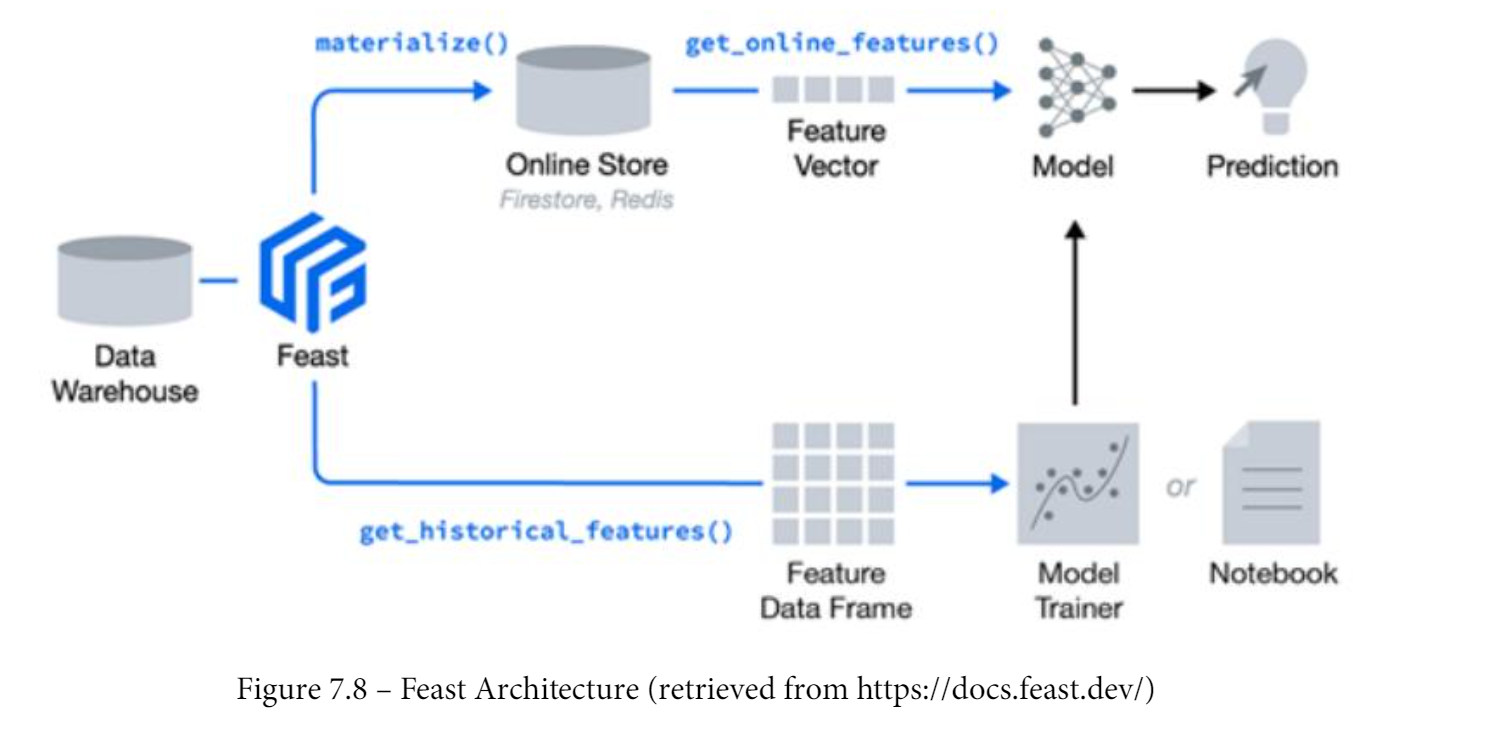

Afin de comprendre comment fonctionne Feast et comment il peut s'intégrer dans votre composant de couche de données (code disponible sur https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/tree/master/Chapter07/psystock_feature_store, exécuter les étapes suivantes :


1.  Install feast:

    
      pip install feast==0.10


2. Initialisez un référentiel de fonctionnalités :


    feast init


3. Créez vos définitions de fonctionnalités en remplaçant le fichier yaml généré automatiquement :


    project: psystock_feature_store
    registry: data/registry.db
    provider: local
    online_store:
        path: data/online_store.db

4. Nous allons maintenant procéder à l'import des dépendances de la dénition de la fonctionnalité :

In [ ]:
# This is an example feature definition file

from google.protobuf.duration_pb2 import Duration

from feast import Entity, Feature, FeatureView, ValueType
from feast.data_source import FileSource
from feast.data_format import ParquetFormat


5. Nous pouvons maintenant charger les fichiers de fonctionnalités :

In [ ]:
# Read data from parquet files. Parquet is convenient for local development mode. For
# production, you can use your favorite DWH, such as BigQuery. See Feast documentation
# for more info.
token_features = FileSource(
    path="./data/features.parquet",
    event_timestamp_column="create_date",
    created_timestamp_column="event_date",
)

driver = Entity(name="token", value_type=ValueType.STRING, description="token id",)

6. Nous pouvons maintenant ajouter une vue des fonctionnalités :

In [ ]:
hourly_view_features_token = FeatureView(
    name="token_hourly_features",
    entities=["token"],
    ttl=Duration(seconds=3600 * 1),
    features=[
        Feature(name="prev_1days", dtype=ValueType.INT64),
        Feature(name="prev_2days", dtype=ValueType.INT64),
        Feature(name="prev_3days", dtype=ValueType.INT64),
        Feature(name="prev_4days", dtype=ValueType.INT64),
        Feature(name="prev_5days", dtype=ValueType.INT64),
        Feature(name="prev_6days", dtype=ValueType.INT64),
        Feature(name="prev_7days", dtype=ValueType.INT64),
        Feature(name="prev_8days", dtype=ValueType.INT64),
        Feature(name="prev_9days", dtype=ValueType.INT64),
        Feature(name="prev_10days", dtype=ValueType.INT64),
        Feature(name="prev_11days", dtype=ValueType.INT64),
        Feature(name="prev_12days", dtype=ValueType.INT64),
        Feature(name="prev_13days", dtype=ValueType.INT64)
    ],
    online=True,
    input=token_features,
    tags={},
)

7. Pour déployer le magasin de fonctionnalités avec les configurations ajoutées jusqu'à présent, nous devons exécuter la commande suivante :


      feast apply

A ce stade, le magasin de fonctionnalités est déployé dans votre environnement (localement dans ce cas) et le magasin de fonctionnalités est disponible pour être utilisé à partir de votre tâche MLflow


8. Nous pouvons maintenant effectuer la récupération de fonctionnalités, maintenant que toutes les fonctionnalités sont stockées dans un magasin de fonctionnalités 

In [ ]:
import pandas as pd
from datetime import datetime

# entity_df generally comes from upstream systems
entity_df = pd.DataFrame.from_dict({
    "token": ["btc","btc","btc","btc"],
    "event_date": [
        datetime(2021, 4, 12, 10, 59, 42),
        datetime(2021, 4, 12, 8,  12, 10),
        datetime(2021, 4, 12, 16, 40, 26),
        datetime(2021, 4, 12, 15, 1 , 12)
    ]
})

entity_df.head()

In [ ]:
from feast import FeatureStore

store = FeatureStore(repo_path=".")

training_df = store.get_historical_features(
    entity_df=entity_df, 
    feature_refs = [
        'token_hourly_features:prev_3days',
        'token_hourly_features:prev_4days',
        'token_hourly_features:prev_5days'        
    ],
).to_df()

training_df.head()

Vous pouvez désormais intégrer votre référentiel de magasin de fonctionnalités dans vos charges de travail MLflow. Avec cette section, nous avons conclu la description duprocessus de gestion des données et de génération de fonctionnalités dans un pipeline de données implémenté avec le module MLProjects dans MLflow. Nous sommes maintenant prêts à traiter les déploiements d'environnement de production dans les chapitres suivants.